<a href="https://colab.research.google.com/github/JiteshKumar9/SMS-Spam-Classification/blob/main/SMS_Spam_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

In [36]:
# Load dataset
dataset = pd.read_csv("SMSSpamCollection.csv", sep="\t", names=['label', 'message'])

In [38]:
dataset

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [39]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   int64 
 1   message  5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [40]:
dataset.isnull().sum()

,0
label,0
message,0


In [41]:
dataset.describe()

,label
count,5572.000000
mean,0.134063
std,0.340751
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [42]:
# Data Preprocessing
dataset['label'] = dataset['label'].map({'ham': 0, 'spam': 1})

In [43]:
dataset

,label,message
0,NaN,"Go until jurong point, crazy.. Available only ..."
1,NaN,Ok lar... Joking wif u oni...
2,NaN,Free entry in 2 a wkly comp to win FA Cup fina...
3,NaN,U dun say so early hor... U c already then say...
4,NaN,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,NaN,This is the 2nd time we have tried 2 contact u...
5568,NaN,Will ü b going to esplanade fr home?
5569,NaN,"Pity, * was in mood for that. So...any other s..."
5570,NaN,The guy did some bitching but I acted like i'd...


In [44]:
dataset.describe()

,label
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


Text(0, 0.5, 'Count')

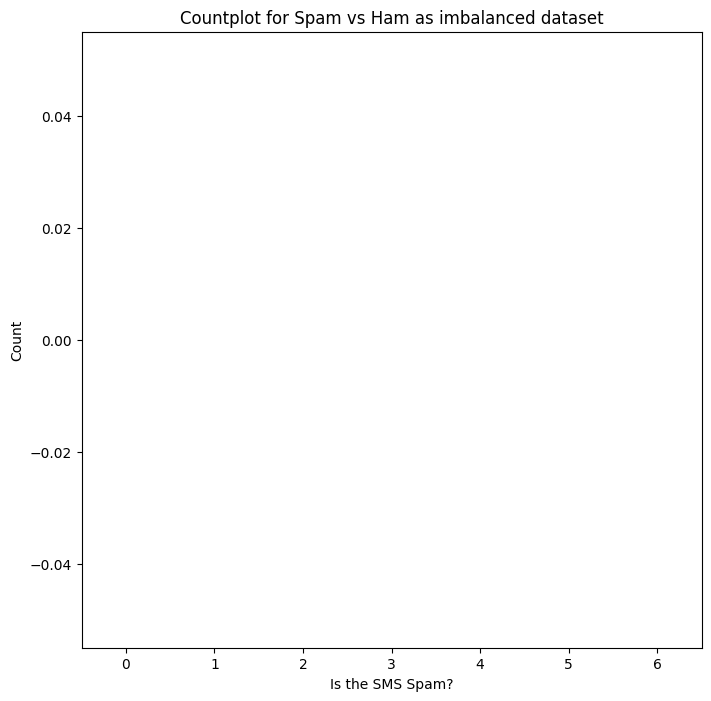

In [45]:
# Countplot for Spam vs Ham
plt.figure(figsize=(8,8))
sns.countplot(x="label", data=dataset)
plt.title('Countplot for Spam vs Ham as imbalanced dataset')
plt.xlabel('Is the SMS Spam?')
plt.ylabel('Count')

In [47]:
# Handle imbalance by oversampling spam messages
only_spam = dataset[dataset['label'] == 1]

# Check if there are any spam messages
if only_spam.shape[0] == 0:
    print("No spam messages found in the dataset!")
else:
    # Calculate the number of times to oversample
    count = int((dataset.shape[0] - only_spam.shape[0]) / only_spam.shape[0])

    # Oversample spam messages
    for i in range(count - 1):
        dataset = pd.concat([dataset, only_spam])

    dataset.reset_index(drop=True, inplace=True)



No spam messages found in the dataset!


In [48]:
# Drop the 'label' column for now (if needed for certain steps)
dataset = dataset.drop(['label'], axis=1)

Text(0, 0.5, 'Count')

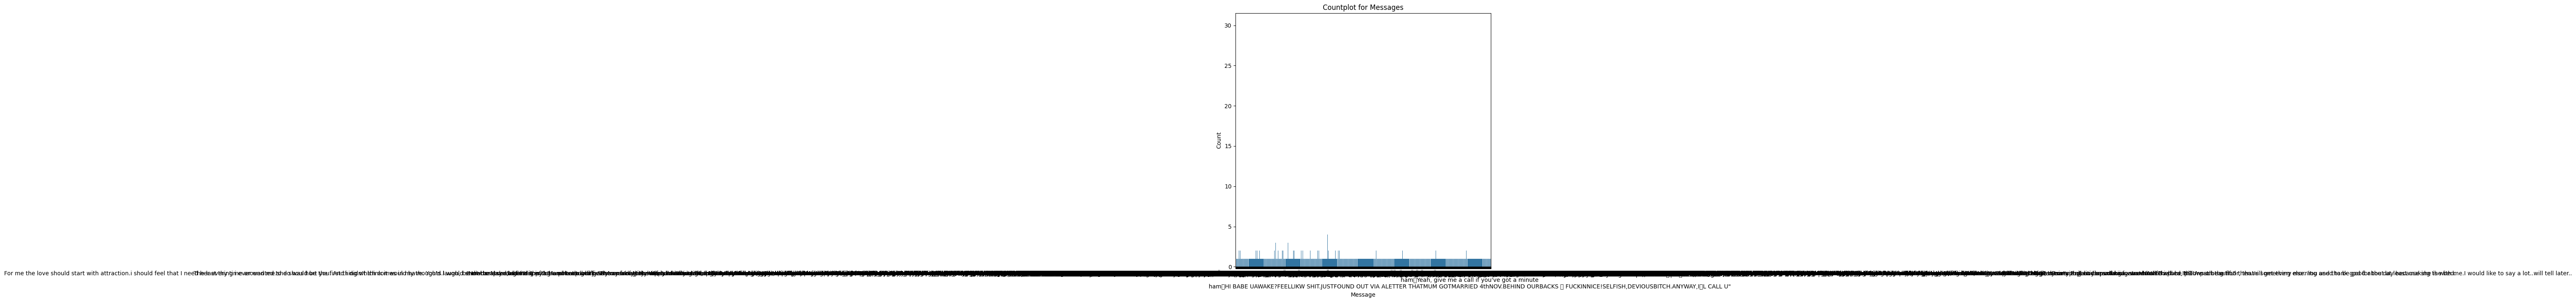

In [49]:
# Countplot for Messages
plt.figure(figsize=(8,8))
sns.countplot(x="message", data=dataset)
plt.title('Countplot for Messages')
plt.xlabel('Message')
plt.ylabel('Count')

In [53]:
# Add word count feature
dataset['word_count'] = dataset['message'].apply(lambda x: len(x.split()))

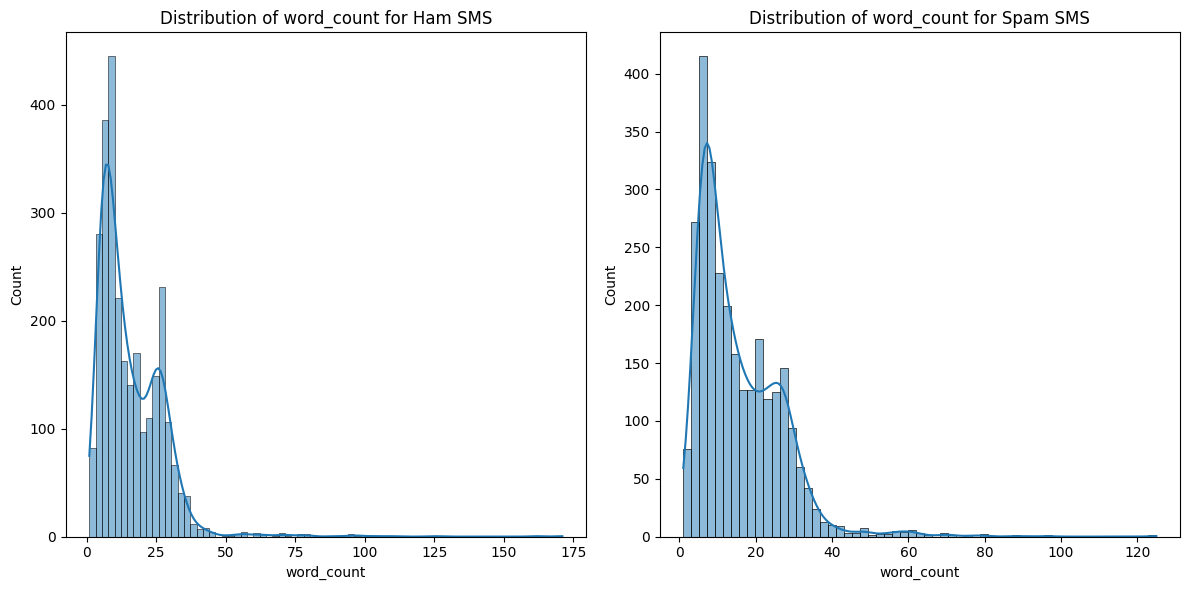

In [55]:
# Distribution of word_count for Ham and Spam SMS
plt.figure(figsize=(12,6))

# Assuming 'label' column was dropped and now you have a balanced dataset
# where the first half is ham and the second half is spam
ham_dataset = dataset.iloc[:len(dataset)//2]  # Select first half as ham
spam_dataset = dataset.iloc[len(dataset)//2:] # Select second half as spam

plt.subplot(1,2,1)
sns.histplot(ham_dataset.word_count, kde=True)
plt.title('Distribution of word_count for Ham SMS')

plt.subplot(1,2,2)
sns.histplot(spam_dataset.word_count, kde=True)
plt.title('Distribution of word_count for Spam SMS')

plt.tight_layout()
plt.show()

In [56]:
# Function to check if message contains currency symbols
def currency(data):
    currency_symbols = ['$','€','£','¥','₹']
    for symbol in currency_symbols:
        if symbol in data:
            return 1
    return 0

dataset["contains_currency_symbol"] = dataset["message"].apply(currency)

In [62]:
# Before Countplot (assuming balanced dataset, label is 0 for first half, 1 for second half)
dataset['label'] = [0] * (len(dataset) // 2) + [1] * (len(dataset) // 2)

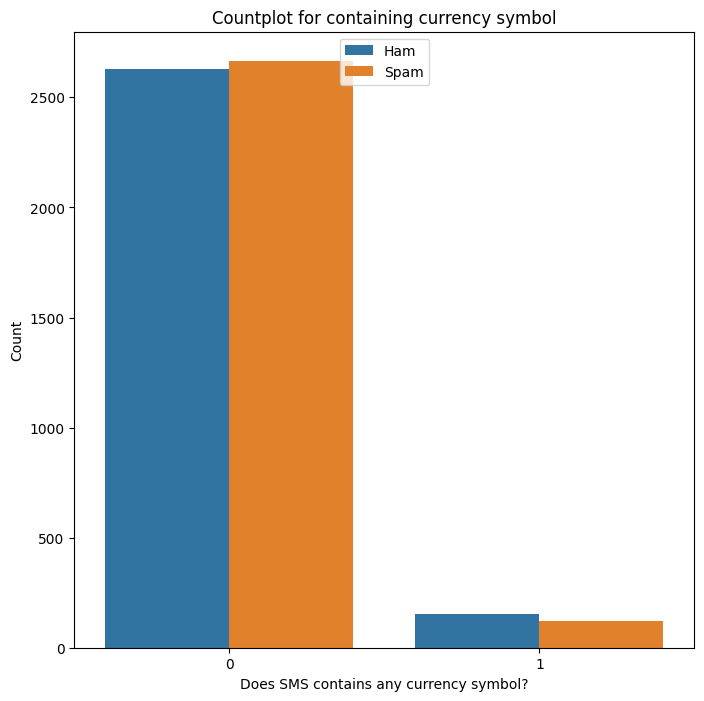

In [63]:
# Countplot for containing currency symbol
plt.figure(figsize=(8,8))
sns.countplot(x="contains_currency_symbol", data=dataset, hue="label")
plt.title('Countplot for containing currency symbol')
plt.xlabel('Does SMS contains any currency symbol?')
plt.ylabel('Count')
plt.legend(labels=["Ham", "Spam"], loc=9) #Corrected legend
plt.show()

In [64]:
# Data Cleaning and Lemmatization
nltk.download('stopwords')
nltk.download('wordnet')
corpus = []
wnl = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [65]:
for sms in list(dataset.message):
    message = re.sub(pattern='[^a-zA-Z]', repl=' ', string=sms)  # Filtering out special characters and numbers
    message = message.lower()
    words = message.split()  # Tokenization
    filtered_words = [word for word in words if word not in set(stopwords.words('english'))]
    lemm_words = [wnl.lemmatize(word) for word in filtered_words]
    message = ' '.join(lemm_words)
    corpus.append(message)

In [66]:
# Creating the Bag of Words model using TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=500)
vectors = tfidf.fit_transform(corpus).toarray()
feature_names = tfidf.get_feature_names_out()

In [67]:
x = pd.DataFrame(vectors, columns=feature_names)
y = dataset['label']

In [68]:
# Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [69]:
# Naive Bayes Model
mnb = MultinomialNB()
cv = cross_val_score(mnb, x, y, scoring='f1', cv=10)
print("Naive Bayes Model F1 Score: ", round(cv.mean(), 3))
print("Naive Bayes Model F1 Score Std: ", round(cv.std(), 3))

Naive Bayes Model F1 Score:  0.499
Naive Bayes Model F1 Score Std:  0.01


In [70]:
mnb.fit(x_train, y_train)
y_pred = mnb.predict(x_test)

In [71]:
# Classification Report and Confusion Matrix for Naive Bayes
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.51      0.47      0.49       568
           1       0.49      0.53      0.51       547

    accuracy                           0.50      1115
   macro avg       0.50      0.50      0.50      1115
weighted avg       0.50      0.50      0.50      1115



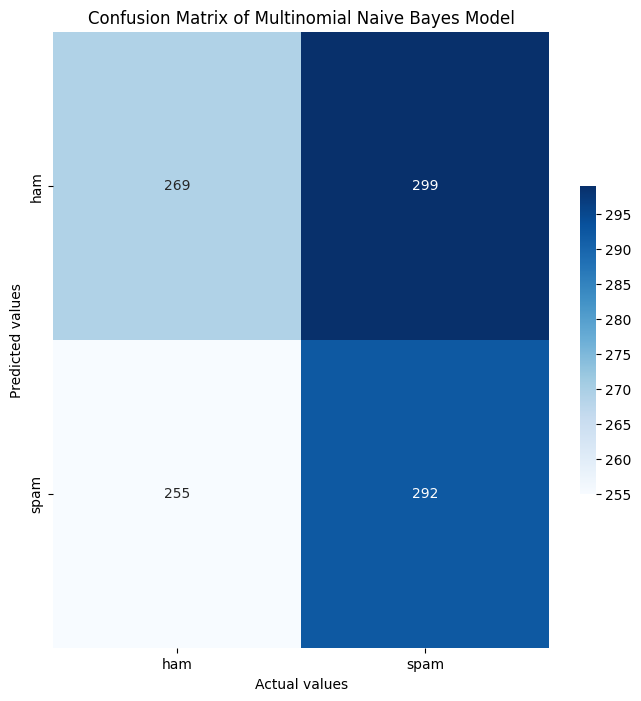

In [72]:
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'], cbar_kws={"shrink": 0.5})
plt.title("Confusion Matrix of Multinomial Naive Bayes Model")
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()

In [73]:
# Decision Tree Model
dt = DecisionTreeClassifier()
cv1 = cross_val_score(dt, x, y, scoring='f1', cv=10)
print("Decision Tree Model F1 Score: ", round(cv1.mean(), 3))
print("Decision Tree Model F1 Score Std: ", round(cv1.std(), 3))

Decision Tree Model F1 Score:  0.469
Decision Tree Model F1 Score Std:  0.03


In [74]:
dt.fit(x_train, y_train)
y_pred1 = dt.predict(x_test)

In [75]:
# Classification Report and Confusion Matrix for Decision Tree
print(classification_report(y_test, y_pred1))
cm = confusion_matrix(y_test, y_pred1)

              precision    recall  f1-score   support

           0       0.50      0.50      0.50       568
           1       0.48      0.48      0.48       547

    accuracy                           0.49      1115
   macro avg       0.49      0.49      0.49      1115
weighted avg       0.49      0.49      0.49      1115



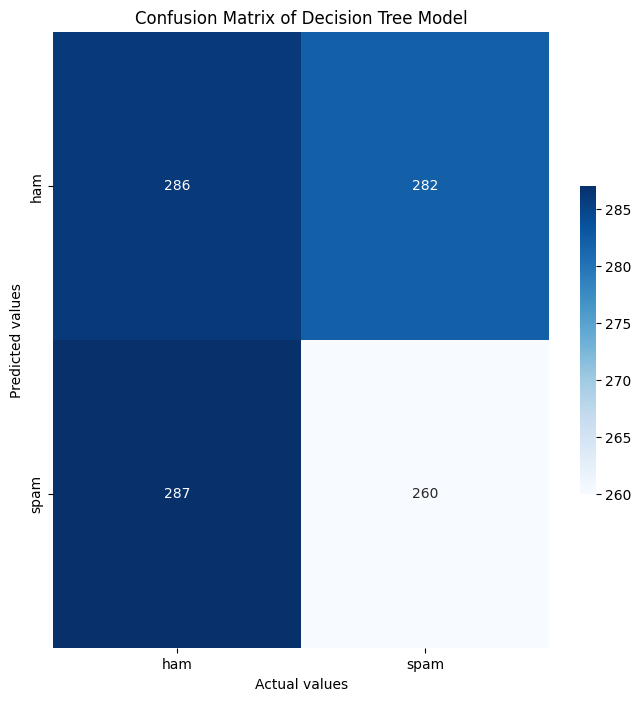

In [76]:
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'], cbar_kws={"shrink": 0.5})
plt.title("Confusion Matrix of Decision Tree Model")
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()

In [77]:
# Predict function
def predict_spam(sms):
    message = re.sub(pattern='[^a-zA-Z]', repl=' ', string=sms)  # Filtering out special characters and numbers
    message = message.lower()
    words = message.split()  # Tokenization
    filtered_words = [word for word in words if word not in set(stopwords.words('english'))]
    lemm_words = [wnl.lemmatize(word) for word in filtered_words]
    message = ' '.join(lemm_words)
    temp = tfidf.transform([message]).toarray()
    return dt.predict(temp)

In [79]:
# Prediction Example
sample_message = 'IMPORTANT - You could be entitled up to 3,160 in compensation from nis-sol PPI on credit card or loan.'

if predict_spam(sample_message):
    print('Gotcha! This is a SPAM message.')
else:
    print('This is a HAM (normal) message')

Gotcha! This is a SPAM message.


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
